In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df_e = pd.read_csv('final_encoded_with_distance.csv')

In [3]:
df_e = df_e.drop(columns=['latitude'])
df_e = df_e.drop(columns=['longitude'])

In [4]:
area_dummy_columns = [col for col in df_e.columns if col.startswith('district_')]

df_e = df_e.drop(columns=area_dummy_columns)

In [5]:
area_dummy_columns = [col for col in df_e.columns if col.startswith('area_')]

df_e = df_e.drop(columns=area_dummy_columns)

In [6]:
df_e

,price,metro_time,info_total_area,floor_ratio,firt_floor,last_floor,rooms_1,rooms_2,rooms_3,rooms_4,...,rent_living_conditions_можно с детьми и животными,rent_living_conditions_можно с животными,"rent_living_conditions_ни с детьми, ни с животными",year_built_interval_1890-1917,year_built_interval_1917-1945,year_built_interval_1945-1970,year_built_interval_1970-1990,year_built_interval_1991-2025,year_built_interval_не попал,distance
0,470000,7.0,73.0,0.683333,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,3.638873
1,270000,13.0,68.0,0.522727,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,3.638873
2,30000,9.0,40.0,0.333333,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,18.568265
3,75000,13.0,60.0,0.375000,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,5.710850
4,29000,7.0,12.0,0.611111,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,4.332863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,65000,5.0,27.0,0.133333,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,5.909691
1322,65000,24.0,35.7,0.636364,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,15.986347
1323,65000,6.0,40.0,0.636364,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,16.831483
1324,64000,7.0,22.0,0.333333,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,13.264013


In [7]:
df_e.columns

Index(['price', 'metro_time', 'info_total_area', 'floor_ratio', 'firt_floor',
       'last_floor', 'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4',
       'rooms_студия', 'rent_jkh_включена (без счётчиков)',
       'rent_jkh_включена (счётчики включены)', 'rent_prepayment_1 месяц',
       'rent_prepayment_2 месяца', 'rent_prepayment_3 месяца',
       'rent_term_несколько месяцев', 'rent_term_от года',
       'rent_living_conditions_можно с детьми',
       'rent_living_conditions_можно с детьми и животными',
       'rent_living_conditions_можно с животными',
       'rent_living_conditions_ни с детьми, ни с животными',
       'year_built_interval_1890-1917', 'year_built_interval_1917-1945',
       'year_built_interval_1945-1970', 'year_built_interval_1970-1990',
       'year_built_interval_1991-2025', 'year_built_interval_не попал',
       'distance'],
      dtype='object')

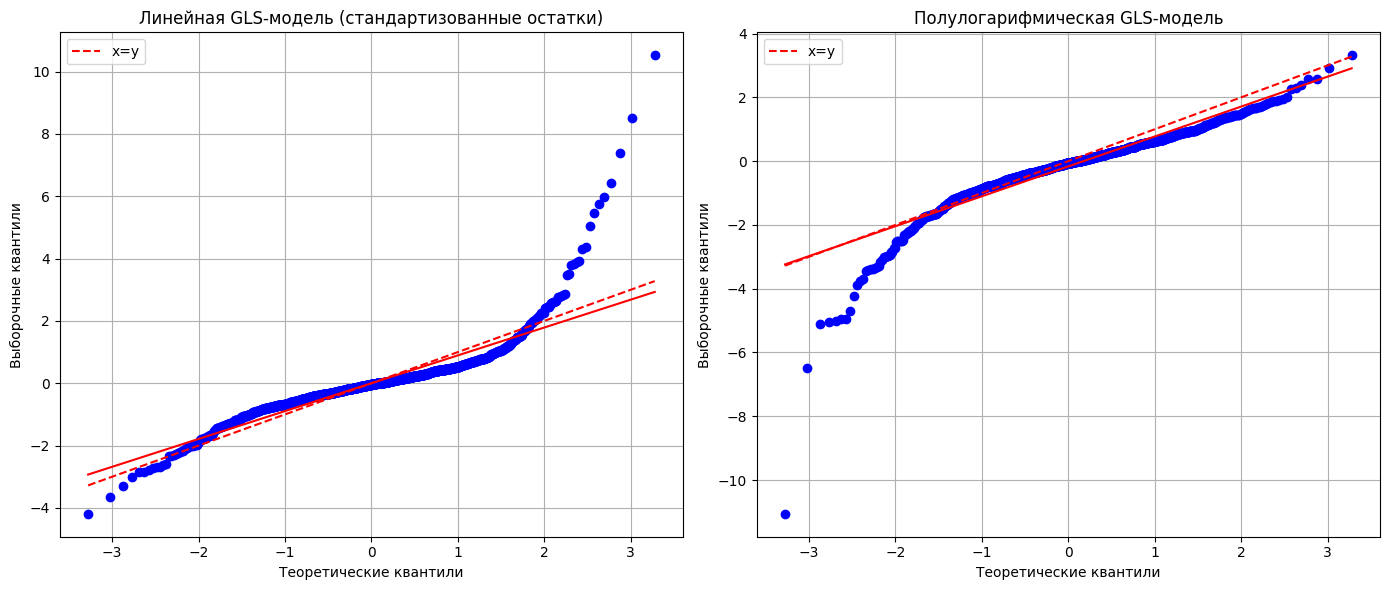

In [12]:
X = df_e.drop("price", axis=1)
y = df_e["price"]
y_log = np.log(y)

ols_model = sm.OLS(y, X).fit()
weights = 1 / (ols_model.resid ** 2 + 1e-6)

wls_model = sm.WLS(y, X, weights=weights).fit()
wls_log_model = sm.WLS(y_log, X, weights=weights).fit()

linear_resids = (y - wls_model.predict(X)) / wls_model.resid.std()
log_resids = (y_log - wls_log_model.predict(X)) / wls_log_model.resid.std()

# Построение графиков
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

def plot_qq(residuals, ax, title):
    (osm, osr), _ = stats.probplot(residuals, dist="norm", plot=ax)
    ax.plot(osm, osm, color='red', linestyle='--', label='x=y')
    ax.set_title(title)
    ax.set_xlabel("Теоретические квантили")
    ax.set_ylabel("Выборочные квантили")
    ax.legend()
    ax.grid(True)

plot_qq(linear_resids, axes[0], "Линейная GLS-модель (стандартизованные остатки)")

plot_qq(log_resids, axes[1], "Полулогарифмическая GLS-модель")

plt.tight_layout()
plt.show()

In [13]:
X = df_e.drop("price", axis=1)
y_linear = df_e["price"]

wls_model = sm.WLS(y, X, weights=weights).fit()
wls_log_model = sm.WLS(y_log, X, weights=weights).fit()

linear_resids = (y - wls_model.predict(X)) / wls_model.resid.std()
log_resids = (y_log - wls_log_model.predict(X)) / wls_log_model.resid.std()

def ks_test(residuals, model_name):
    residuals_standardized = (residuals - residuals.mean()) / residuals.std()

    # Тест Колмогорова-Смирнова
    ks_stat, p_value = stats.kstest(
        residuals_standardized,
        'norm',
        args=(0, 1)
    )

    print(f"Модель: {model_name}")
    print(f"Статистика K-S: {ks_stat:.4f}")
    print(f"P-значение: {p_value:.4f}")
    print("---")

# Проверка для обеих моделей
ks_test(linear_resids, "Линейная модель")
ks_test(log_resids, "Полулогарифмическая модель")


Модель: Линейная модель
Статистика K-S: 0.1451
P-значение: 0.0000
---
Модель: Полулогарифмическая модель
Статистика K-S: 0.0988
P-значение: 0.0000
---


In [14]:
df = df_e

In [15]:
# Создание модели
X = sm.add_constant(df.drop(columns='price')).values
y = df['price']

ols_model = sm.OLS(y, X).fit()
weights = 1 / (ols_model.resid ** 2 + 1e-6)

wls_log_model = sm.WLS(y_log, X, weights=weights).fit()

log_resids = (y_log - wls_log_model.predict(X)) / wls_log_model.resid.std()

# Ручной расчет DFFITS

H = X @ np.linalg.pinv(X.T @ X) @ X.T  # Hat matrix
h = np.diag(H)

p = X.shape[1]  # Количество параметров (включая константу)
n = len(y)

# Расчет стандартных ошибок
s_squared = np.sum(log_resids**2) / (n - p)
s_i = np.sqrt(s_squared * (1 - h))

# Формула DFFITS
dffits = (log_resids / s_i) * np.sqrt(h / (1 - h))

# Пороговое значение
dffits_threshold = 2 * np.sqrt(p / n)

# Фильтрация
non_outliers_mask = np.abs(dffits) <= dffits_threshold
data_filtered_no_outliers = df[non_outliers_mask].reset_index(drop=True)

print(f"Размер до фильтрации: {len(df)}")
print(f"Размер после фильтрации: {len(data_filtered_no_outliers)}")

Размер до фильтрации: 1326
Размер после фильтрации: 1266


In [16]:
import plotly.graph_objects as go

# Визуализация
fig = go.Figure()

# Точки DFFITS
fig.add_trace(go.Scatter(
    x=np.arange(len(dffits)),
    y=dffits,
    mode='markers',
    name='DFFITS',
    marker=dict(
        color=np.where(np.abs(dffits) > dffits_threshold, 'red', 'blue'),
        size=5,
        opacity=0.7
    ),
    hovertemplate="Наблюдение: %{x}<br>DFFITS: %{y:.3f}<extra></extra>"
))

# Пороговые линии
fig.add_hline(
    y=dffits_threshold,
    line_dash="dot",
    line_color="red",
    annotation_text=f"Верхний порог: {dffits_threshold:.2f}",
    annotation_position="top right"
)

fig.add_hline(
    y=-dffits_threshold,
    line_dash="dot",
    line_color="red",
    annotation_text=f"Нижний порог: {-dffits_threshold:.2f}",
    annotation_position="bottom right"
)

# Выделение выбросов
outliers = np.where(np.abs(dffits) > dffits_threshold)[0]
fig.add_trace(go.Scatter(
    x=outliers,
    y=dffits[outliers],
    mode='markers',
    marker=dict(
        color='red',
        size=8,
        symbol='x'
    ),
    name='Выбросы'
))

# Оформление
fig.update_layout(
    title='Анализ выбросов с помощью DFFITS',
    xaxis_title='Номер наблюдения',
    yaxis_title='DFFITS',
    hovermode='closest',
    showlegend=True,
    template='plotly_white',
    height=600,
    yaxis_range=[-4, 4],
)

fig.show()

In [17]:
data_filtered_no_outliers

,price,metro_time,info_total_area,floor_ratio,firt_floor,last_floor,rooms_1,rooms_2,rooms_3,rooms_4,...,rent_living_conditions_можно с детьми и животными,rent_living_conditions_можно с животными,"rent_living_conditions_ни с детьми, ни с животными",year_built_interval_1890-1917,year_built_interval_1917-1945,year_built_interval_1945-1970,year_built_interval_1970-1990,year_built_interval_1991-2025,year_built_interval_не попал,distance
0,470000,7.0,73.0,0.683333,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,3.638873
1,270000,13.0,68.0,0.522727,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,3.638873
2,30000,9.0,40.0,0.333333,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,18.568265
3,75000,13.0,60.0,0.375000,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,5.710850
4,29000,7.0,12.0,0.611111,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,4.332863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,65000,5.0,27.0,0.133333,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,5.909691
1262,65000,24.0,35.7,0.636364,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,15.986347
1263,65000,6.0,40.0,0.636364,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,16.831483
1264,64000,7.0,22.0,0.333333,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,13.264013


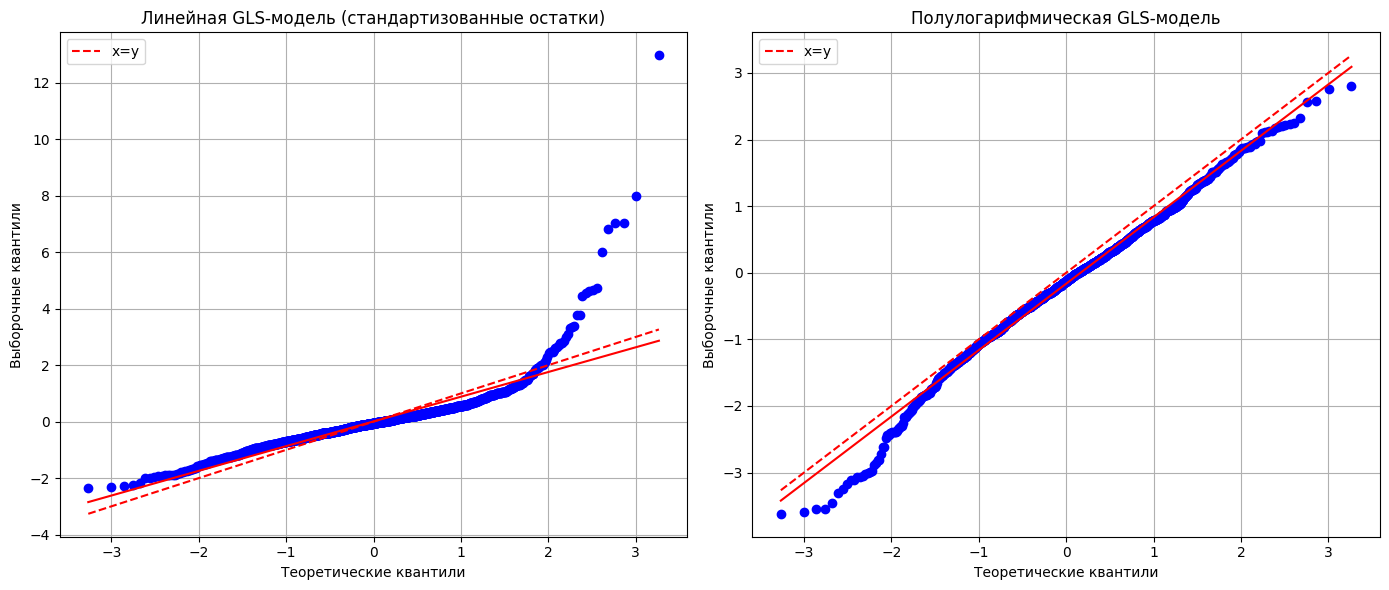

In [18]:
X = data_filtered_no_outliers.drop("price", axis=1)
y = data_filtered_no_outliers["price"]
y_log = np.log(y)

ols_model = sm.OLS(y, X).fit()
weights = 1 / (ols_model.resid ** 2 + 1e-6)

wls_model = sm.WLS(y, X, weights=weights).fit()
wls_log_model = sm.WLS(y_log, X, weights=weights).fit()

linear_resids = (y - wls_model.predict(X)) / wls_model.resid.std()
log_resids = (y_log - wls_log_model.predict(X)) / wls_log_model.resid.std()

# Построение графиков
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Общая функция для построения QQ-plot
def plot_qq(residuals, ax, title):
    (osm, osr), _ = stats.probplot(residuals, dist="norm", plot=ax)
    ax.plot(osm, osm, color='red', linestyle='--', label='x=y')  # Линия x=y
    ax.set_title(title)
    ax.set_xlabel("Теоретические квантили")
    ax.set_ylabel("Выборочные квантили")
    ax.legend()
    ax.grid(True)

plot_qq(linear_resids, axes[0], "Линейная GLS-модель (стандартизованные остатки)")

# График для полулогарифмической модели
plot_qq(log_resids, axes[1], "Полулогарифмическая GLS-модель")

plt.tight_layout()
plt.show()

In [19]:
ks_test(log_resids, "Полулогарифмическая модель")

Модель: Полулогарифмическая модель
Статистика K-S: 0.0355
P-значение: 0.0809
---


In [21]:
def jarque_bera_test(residuals):
    n = len(residuals)
    skewness = stats.skew(residuals)
    kurtosis = stats.kurtosis(residuals, fisher=False)  # Fisher=False возвращает эксцесс Пирсона (kurtosis = E[(X-μ)^4]/σ^4 - 3)

    JB_stat = (n / 6) * (skewness**2 + (kurtosis - 3)**2 / 4)
    p_value = stats.chi2.sf(JB_stat, df=2)  # Распределение χ² с 2 степенями свободы

    return JB_stat, p_value

In [22]:
def shapiro_wilk_test(residuals):
    W_stat, p_value = stats.shapiro(residuals)
    return W_stat, p_value

In [23]:
jb_stat, jb_p = jarque_bera_test(log_resids)
sw_stat, sw_p = shapiro_wilk_test(log_resids)

print(f"Jarque-Bera Test: JB = {jb_stat:.2f}, p-value = {jb_p:.4f}")
print(f"Shapiro-Wilk Test: W = {sw_stat:.3f}, p-value = {sw_p:.4f}")

Jarque-Bera Test: JB = 40.54, p-value = 0.0000
Shapiro-Wilk Test: W = 0.991, p-value = 0.0000


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def pe_test(df, y_col, X_cols):
    """Тест PE для выбора между Y и ln(Y)."""

    # Шаг 1: Извлечение данных
    X = df[X_cols]  # X_cols должен быть списком названий столбцов, например: ["area", "rooms"]
    y = df[y_col]   # y_col должен быть названием столбца, например: "price"

    # Линейная модель (без константы, если она уже есть в данных)
    model_lin = sm.GLS(y, X).fit()
    y_hat_lin = model_lin.predict(X)

    # Лог-линейная модель
    y_log = np.log(y)
    model_log = sm.GLS(y_log, X).fit()
    y_hat_log = model_log.predict(X)

    # Шаг 2: Вспомогательные регрессии
    # Для теста δ_LIN
    aux_data_lin = X.join(pd.Series(y - y_hat_lin, name='res_lin', index=X.index))
    aux_lin = sm.GLS(y, aux_data_lin).fit()

    # Для теста δ_LOG
    aux_data_log = X.join(pd.Series(y_log - y_hat_log, name='res_log', index=X.index))
    aux_log = sm.GLS(y_log, aux_data_log).fit()

    # Шаг 3: Проверка гипотез
    pval_lin = aux_lin.pvalues.get('res_lin', 1)  # Если столбец не найден, возвращаем 1
    pval_log = aux_log.pvalues.get('res_log', 1)

    alpha = 0.05
    reject_lin = pval_lin < alpha
    reject_log = pval_log < alpha

    # Интерпретация
    if not reject_lin and not reject_log:
        return "Не можем выбрать (обе модели допустимы)"
    elif reject_lin and not reject_log:
        return "Выбираем лог-линейную модель (LOG)"
    elif not reject_lin and reject_log:
        return "Выбираем линейную модель (LIN)"
    else:
        return "Не можем выбрать (противоречивые результаты)"

In [ ]:
X_cols = data_filtered_no_outliers.drop("price", axis=1).columns.tolist()
y_col = "price"

result = pe_test(
    df=data_filtered_no_outliers,
    y_col=y_col,
    X_cols=X_cols
)
print(result)

Не можем выбрать (противоречивые результаты)


In [ ]:
from scipy.stats import chi2

# Извлечение данных из DataFrame
y = data_filtered_no_outliers["price"]  # Series
X = data_filtered_no_outliers.drop("price", axis=1)  # DataFrame

# Модель 1: Линейная
model_1 = sm.GLS(y, X).fit()
RSS_1 = model_1.resid.dot(model_1.resid)

# Модель 2: Повторная (для проверки)
model_2 = sm.GLS(y, X).fit()
RSS_2 = model_2.resid.dot(model_2.resid)

df_new_2 = data_filtered_no_outliers.copy()  # Сохраняем исходные индексы!
gY = np.exp(np.mean(np.log(y)))
df_new_2['Y_star'] = y / gY  # y берется из исходного DataFrame (индексы совпадают с X)

# Модель 3: Линейная с масштабированным Y
model_3 = sm.GLS(df_new_2['Y_star'], X).fit()  # Теперь индексы совпадают
RSS_3 = model_3.resid.dot(model_3.resid)

# Модель 4: Полулогарифмическая (исправлена опечатка GLSLS -> GLS)
model_4 = sm.GLS(np.log(df_new_2['Y_star']), X).fit()
RSS_4 = model_4.resid.dot(model_4.resid)

# Расчёт критерия
n = len(df_new_2)
chi_squared_stat = (n / 2) * np.abs(np.log(RSS_3 / RSS_4))
chi_squared_critical = chi2.ppf(0.95, 1)

# Вывод результатов
if chi_squared_stat > chi_squared_critical:
    print("Гипотеза H0 отвергается: между моделями есть значимое различие.")
    print("Модель (3) (линейная) лучше." if RSS_3 < RSS_4 else "Модель (4) (полулогарифмическая) лучше.")
else:
    print("Гипотеза H0 не отвергается: модели одинаковы по качеству подгонки.")

Гипотеза H0 отвергается: между моделями есть значимое различие.
Модель (4) (полулогарифмическая) лучше.


In [ ]:
print(chi_squared_critical)
print(chi_squared_stat)
print(RSS_1)
print(RSS_2)

3.841458820694124
327.7895596795673
383277929533.0196
383277929533.0196


In [24]:
data_filtered_no_outliers.to_csv('data_after_normality.csv', index=False)
print("Файл сохранён как data_after_normality.csv")

Файл сохранён как data_after_normality.csv
